In [1]:
%load_ext autoreload
%autoreload 2

from datetime import datetime

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

from myutil import Parameters
import models
import losses
import dataloader

params = Parameters('parameters.json')
generator = models.generator_6blocks
discriminator = models.discriminator

TIME_FORMAT = datetime.now().strftime('%h-%d-%Y-%Hh%Mm%Ss')

In [2]:
def show_image(image):
    plt.imshow(((image + 1) / 2).clip(0, 1))
    plt.axis('off')
    plt.show()
    
def show_4_images(images):
    plt.figure(figsize=(12, 12))
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.imshow(((images[i] + 1) / 2).clip(0, 1))
        plt.axis('off')
    plt.show()
        
cdl = dataloader.CycleDataLoader(params.FILE_DIR_A, params.FILE_DIR_B, 
                                 batch_size=params.BATCH_SIZE, crop_size=params.HEIGHT)


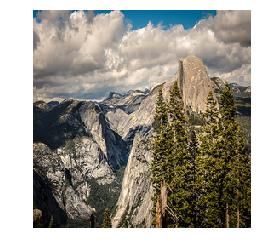

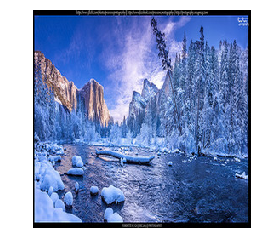

In [3]:
batch_a, batch_b = cdl.get_batch()

show_image(batch_a[0])
show_image(batch_b[0])

In [ ]:
with tf.Graph().as_default() as graph:
    
    # Create placeholders
    real_images_a = tf.placeholder(tf.float32, 
                                   [params.BATCH_SIZE, params.HEIGHT, params.WIDTH, params.CHANNELS])
    real_images_b = tf.placeholder(tf.float32, 
                                   [params.BATCH_SIZE, params.HEIGHT, params.WIDTH, params.CHANNELS])

    fake_pool_a = tf.placeholder(tf.float32, 
                                 [params.BATCH_SIZE, params.HEIGHT, params.WIDTH, params.CHANNELS])
    fake_pool_b = tf.placeholder(tf.float32, 
                                 [params.BATCH_SIZE, params.HEIGHT, params.WIDTH, params.CHANNELS])

    # First time using discriminator_A and discriminator_B. used for BCE loss for each discrim
    prob_real_a = discriminator(real_images_a, name="discriminator_A", reuse=False)
    prob_real_b = discriminator(real_images_b, name="discriminator_B", reuse=False)
    
    # First time using generator_A and generator_B. Create the fake images
    fake_images_b = generator(real_images_a, name="generator_A", reuse=False)
    fake_images_a = generator(real_images_b, name="generator_B", reuse=False)
    
    # Now reusing discriminator_A and discriminator_B. used for nll loss for each generator
    prob_fake_a = discriminator(fake_images_a, name="discriminator_A", reuse=True)
    prob_fake_b = discriminator(fake_images_b, name="discriminator_B", reuse=True)
    
    # Now reusing generator_A and generator_B. Cycle images used for cycle loss
    cycle_images_b = generator(fake_images_a, name="generator_A", reuse=True)
    cycle_images_a = generator(fake_images_b, name="generator_B", reuse=True)
    
    # Again reusing discriminator_A and discriminator_B. used for BCE loss for each discrim.
    prob_fake_pool_a = discriminator(fake_pool_a, name="discriminator_A", reuse=True)
    prob_fake_pool_b = discriminator(fake_pool_b, name="discriminator_B", reuse=True)
    
    # Now let's define some losses....
    # LSGAN Discriminator losses
    loss_discrim_a = losses.lsgan_loss_discriminator(prob_real_a, prob_fake_pool_a)
    loss_discrim_b = losses.lsgan_loss_discriminator(prob_real_b, prob_fake_pool_b)
    
    # LSGAN generator losses
    loss_lsgan_generator_a = losses.lsgan_loss_generator(prob_fake_a)
    loss_lsgan_generator_b = losses.lsgan_loss_generator(prob_fake_b)
    
    # Cycle consistency losses
    loss_cycle_a = params.LAMBDA_A * losses.cycle_consistency_loss(real_images_a, cycle_images_a)
    loss_cycle_b = params.LAMBDA_B * losses.cycle_consistency_loss(real_images_b, cycle_images_b)
    
    # Total Generator loss (cycle consistency losses + LSGAN generator loss)
    loss_generator_a = loss_lsgan_generator_a + loss_cycle_a + loss_cycle_b
    loss_generator_b = loss_lsgan_generator_b + loss_cycle_a + loss_cycle_b
    
    
    # Extract the correct variables for optimization
    trainable_variables = tf.trainable_variables()
    d_A_vars = [var for var in trainable_variables if 'discriminator_A' in var.name]
    d_B_vars = [var for var in trainable_variables if 'discriminator_B' in var.name]
    g_A_vars = [var for var in trainable_variables if 'generator_A' in var.name]
    g_B_vars = [var for var in trainable_variables if 'generator_B' in var.name]
    
    
    # Optimizer operations
    d_A_optim = tf.train.AdamOptimizer(params.D_LEARNING_RATE)\
                    .minimize(loss_discrim_a, var_list=d_A_vars)
    
    d_B_optim = tf.train.AdamOptimizer(params.D_LEARNING_RATE)\
                    .minimize(loss_discrim_b, var_list=d_B_vars)
    
    g_A_optim = tf.train.AdamOptimizer(params.G_LEARNING_RATE)\
                    .minimize(loss_generator_a, var_list=g_A_vars)
    
    g_B_optim = tf.train.AdamOptimizer(params.G_LEARNING_RATE)\
                    .minimize(loss_generator_b, var_list=g_B_vars)
    
    d_A_loss_summ = tf.summary.scalar("d_A_loss", loss_discrim_a)
    d_B_loss_summ = tf.summary.scalar("d_B_loss", loss_discrim_b)    
    g_A_loss_summ = tf.summary.scalar("g_A_loss", loss_generator_a)
    g_B_loss_summ = tf.summary.scalar("g_B_loss", loss_generator_b)

In [ ]:
with tf.Session(graph=graph) as sess:
    saver = tf.train.Saver()
    writer = tf.summary.FileWriter("./runs/{}_{}".format(params.RUN_NAME, TIME_FORMAT), sess.graph)
    summary_step = 0
    
    init = tf.global_variables_initializer()
    sess.run(init)
    
    fake_pool_a_data = np.zeros((params.POOL_SIZE, params.HEIGHT, params.WIDTH, params.CHANNELS))
    fake_pool_b_data = np.zeros((params.POOL_SIZE, params.HEIGHT, params.WIDTH, params.CHANNELS))
    n_fakes = 0
    
    
    for i in range(int(params.N_ITERS)):
        batch_a, batch_b = cdl.get_batch()


        # Update generators and get the fake images
        (_, fake_b, summary_g_A, 
         _, fake_a, summary_g_B) = sess.run([g_A_optim, fake_images_b, g_A_loss_summ,
                                              g_B_optim, fake_images_a, g_B_loss_summ],
                                         feed_dict={
                                             real_images_a: batch_a,
                                             real_images_b: batch_b
                                         })

        # Use fake images to update discriminators
        (_, summary_d_B,
         _, summary_d_A) = sess.run([d_B_optim, d_B_loss_summ, d_A_optim, d_A_loss_summ],
                                 feed_dict={
                                     real_images_a: batch_a,
                                     real_images_b: batch_b,
                                     fake_pool_b: models.fake_image_pool(n_fakes, fake_b, fake_pool_b_data),
                                     fake_pool_a: models.fake_image_pool(n_fakes, fake_a, fake_pool_a_data)
                                 })

        writer.add_summary(summary_g_A, summary_step)
        writer.add_summary(summary_d_B, summary_step)
        writer.add_summary(summary_g_B, summary_step)
        writer.add_summary(summary_d_A, summary_step)
        summary_step += 1
        n_fakes += 1

        if i % 64 == 0:
            print(f"------Iteration {i} / {int(params.N_ITERS)}------")
            show_4_images([fake_a[0], batch_a[0], fake_b[0], batch_b[0]])
            save_path = saver.save(sess, "./checkpoints/{}".format(params.RUN_NAME))
            print(save_path)